In [1]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from itertools import combinations
import csv
import datetime
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
import random

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [31]:
#phase_dir = '../phased_ihart.ms2_quads_del'
#ped_file = '../../DATA/ihart.ms2/ihart.ped'
#assembly = '38'

phase_dir = '../phased_spark2_quads_del'
ped_file = '../../DATA/spark/sparkfam.ped'
assembly = '38'

#phase_dir = '../phased_ancestry_quads_del'
#ped_file = '../../DATA/ancestry/ancestry.ped.quads.ped'
#assembly = '38'

In [32]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
			if pieces[2] != '0' and pieces[3] != '0':
				parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children
sample_to_affected, sample_to_sex, parents_to_children = pull_phenotype_ped(ped_file)

In [33]:
sibpair_to_num_crossovers_mat = dict()
sibpair_to_num_crossovers_pat = dict()

sibpair_to_num_gcs_mat = dict()
sibpair_to_num_gcs_pat = dict()

mom_child_pairs = set()
dad_child_pairs = set()

# preferentially pull aut-aut and nt-nt sibpairs
for file in os.listdir(phase_dir):
    if file.endswith('.crossovers.json'):
        child1, child2 = file.split('.')[1:3]
            
        with open('%s/%s' % (phase_dir, file), 'r') as f:
            cos = json.load(f)

        with open('%s/%sgene_conversions.json' % (phase_dir, file[:-15]), 'r') as f:
            gcs = json.load(f)

        if len(cos)>0:
            assert (child1, child2) == tuple(cos[0]['child']) or (child2, child1) == tuple(cos[0]['child']) 
        if len(gcs)>0:
            assert (child1, child2) == tuple(gcs[0]['child']) or (child2, child1) == tuple(gcs[0]['child'])

        if len(cos)<200 and len(gcs)<200:
            sibpair_to_num_crossovers_mat[(child1, child2)] = len([x for x in cos if x['is_mat']])
            sibpair_to_num_crossovers_pat[(child1, child2)] = len([x for x in cos if x['is_pat']])
            sibpair_to_num_gcs_mat[(child1, child2)] = len([x for x in gcs if x['is_mat']])
            sibpair_to_num_gcs_pat[(child1, child2)] = len([x for x in gcs if x['is_pat']])

            mom_child_pairs.add((cos[0]['mom'], child1))
            mom_child_pairs.add((cos[0]['mom'], child2))
            dad_child_pairs.add((cos[0]['dad'], child1))
            dad_child_pairs.add((cos[0]['dad'], child2))
                
print(len(sibpair_to_num_crossovers_mat), len(sibpair_to_num_crossovers_pat), 
      len(sibpair_to_num_gcs_mat), len(sibpair_to_num_gcs_mat))

6513 6513 6513 6513


In [34]:
print(len([x for x in sibpair_to_num_gcs_mat.keys() if sample_to_affected[x[0]]=='1' and sample_to_affected[x[1]]=='1']))
print(len([x for x in sibpair_to_num_gcs_mat.keys() if sample_to_affected[x[0]]=='2' and sample_to_affected[x[1]]=='2']))
print(len([x for x in sibpair_to_num_gcs_mat.keys() if sample_to_affected[x[0]]!='1']))



113
1453
6174


In [38]:
# estimate the number of crossovers/gene conversion events for each child
child_to_num_crossovers_mat = dict()
child_to_num_crossovers_pat = dict()
child_to_num_gcs_mat = dict()
child_to_num_gcs_pat = dict()

for (mom, dad), children in parents_to_children.items():
    sibpairs = []
    siblings = set()
    for sib1, sib2 in combinations(children, 2):
        if (sib1, sib2) in sibpair_to_num_crossovers_mat:
            sibpairs.append((sib1, sib2))
            siblings.add(sib1)
            siblings.add(sib2)
        elif (sib2, sib1) in sibpair_to_num_crossovers_mat:
            sibpairs.append((sib2, sib1))
            siblings.add(sib1)
            siblings.add(sib2)
            
    siblings = sorted(siblings)
    
    if len(sibpairs)>= len(siblings) and len(siblings)>0:
        X = np.zeros((len(sibpairs), len(siblings)))
        y_mat_co = np.zeros((len(sibpairs),))
        y_pat_co = np.zeros((len(sibpairs),))
        y_mat_gc = np.zeros((len(sibpairs),))
        y_pat_gc = np.zeros((len(sibpairs),))
        for i, sibpair in enumerate(sibpairs):
            X[i, siblings.index(sibpair[0])] = 1
            X[i, siblings.index(sibpair[1])] = 1
            y_mat_co[i] = sibpair_to_num_crossovers_mat[sibpair]
            y_pat_co[i] = sibpair_to_num_crossovers_pat[sibpair]
            y_mat_gc[i] = sibpair_to_num_gcs_mat[sibpair]
            y_pat_gc[i] = sibpair_to_num_gcs_pat[sibpair]
                
            counts, _ = opt.nnls(X, y_mat_gc)
            for child, count in zip(siblings, counts):
                child_to_num_gcs_mat[child] = count
                
            counts, _ = opt.nnls(X, y_pat_gc)
            for child, count in zip(siblings, counts):
                child_to_num_gcs_pat[child] = count
                
            
        counts, _, _, _ = np.linalg.lstsq(X, np.hstack((y_mat_co[:, np.newaxis], y_pat_co[:, np.newaxis])))
        for child, count in zip(siblings, counts):
            child_to_num_crossovers_mat[child], child_to_num_crossovers_pat[child] = count
print(len(child_to_num_crossovers_mat))
print(len([x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]=='2']))
print(len([x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]=='1']))

1392
969
422


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [39]:
print(len(child_to_num_crossovers_mat), len(child_to_num_crossovers_pat))
print(sum(len(child_to_num_crossovers_mat)*stats.poisson.pmf(np.arange(100), 28)))

1392 1392
1391.9999999999993


40.99999999999998 42
26.333333333333336 28
69.43611790311492
19.20263357698321
41.33333333333334 42
26.00000000000001 28
63.034272474747915
19.01532919180129


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

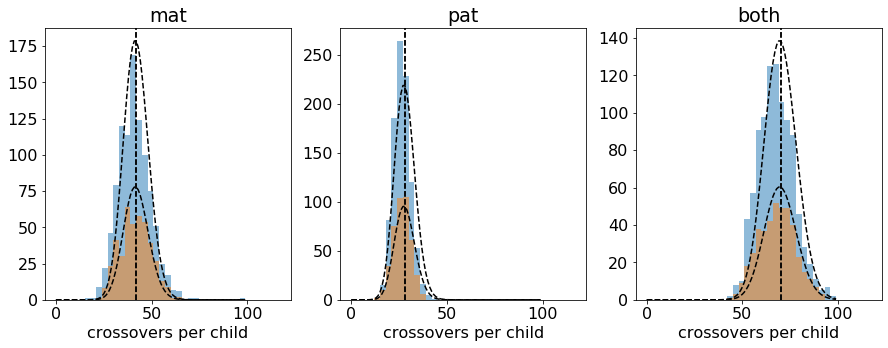

In [40]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 5))

for phen in ['2', '1']:
    children = [x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]==phen]

    print(np.median([child_to_num_crossovers_mat[x] for x in children]), 42)
    print(np.median([child_to_num_crossovers_pat[x] for x in children]), 28)
    
    print(np.std([child_to_num_crossovers_mat[x] for x in children])**2)
    print(np.std([child_to_num_crossovers_pat[x] for x in children])**2)

    binsize = 3
    bins = np.arange(0, 120, binsize)

    plt.subplot(1, 3, 1)
    plt.hist(np.clip([child_to_num_crossovers_mat[x] for x in children], 0, 119), bins=bins, alpha=0.5, label='mat')
    plt.axvline(42, linestyle='--', color='black')
    plt.plot(np.arange(100), binsize*len(children)*stats.poisson.pmf(np.arange(100), 42), color='black', linestyle='--')
    plt.title('mat')
    plt.xlabel('crossovers per child')

    plt.subplot(1, 3, 2)
    plt.hist(np.clip([child_to_num_crossovers_pat[x] for x in children], 0, 119), bins=bins, alpha=0.5, label='pat')
    plt.axvline(28, linestyle='--', color='black')
    plt.plot(np.arange(100), binsize*len(children)*stats.poisson.pmf(np.arange(100), 28), color='black', linestyle='--')
    plt.title('pat')
    plt.xlabel('crossovers per child')

    plt.subplot(1, 3, 3)
    plt.hist(np.clip([child_to_num_crossovers_mat[x]+child_to_num_crossovers_pat[x] for x in children], 0, 119), 
             bins=bins, alpha=0.5, label='both')
    plt.axvline(42+28, linestyle='--', color='black')
    plt.plot(np.arange(100), binsize*len(children)*stats.poisson.pmf(np.arange(100), 42+28), color='black', linestyle='--')
    plt.title('both')
    plt.xlabel('crossovers per child')

plt.show()

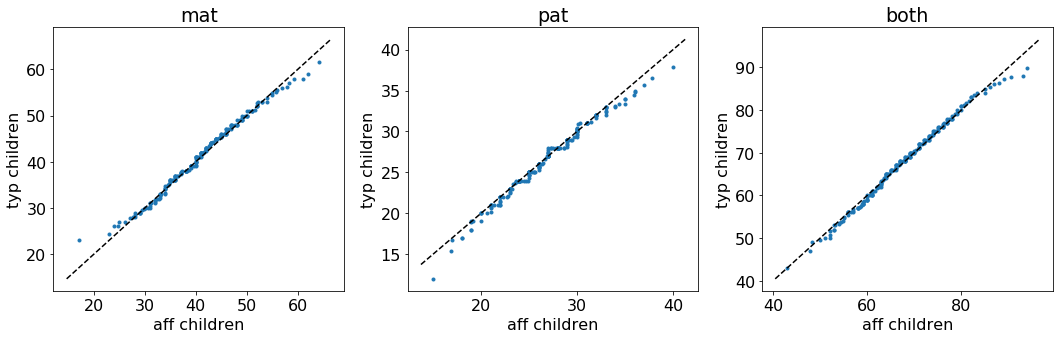

In [41]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 5))

aff_children = [x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]=='2']
typ_children = [x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]=='1']

bins = np.arange(0, 1, 0.005)

plt.subplot(1, 3, 1)
plt.scatter(np.quantile([child_to_num_crossovers_mat[x] for x in aff_children], bins), 
            np.quantile([child_to_num_crossovers_mat[x] for x in typ_children], bins),
            label='mat', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('mat')
plt.xlabel('aff children')
plt.ylabel('typ children')

plt.subplot(1, 3, 2)
plt.scatter(np.quantile([child_to_num_crossovers_pat[x] for x in aff_children], bins), 
            np.quantile([child_to_num_crossovers_pat[x] for x in typ_children], bins),
            label='pat', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('pat')
plt.xlabel('aff children')
plt.ylabel('typ children')

plt.subplot(1, 3, 3)
plt.scatter(np.quantile([child_to_num_crossovers_mat[x]+child_to_num_crossovers_pat[x] for x in aff_children], bins), 
            np.quantile([child_to_num_crossovers_mat[x]+child_to_num_crossovers_pat[x] for x in typ_children], bins),
            label='both', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('both')
plt.xlabel('aff children')
plt.ylabel('typ children')

plt.tight_layout()
plt.show()

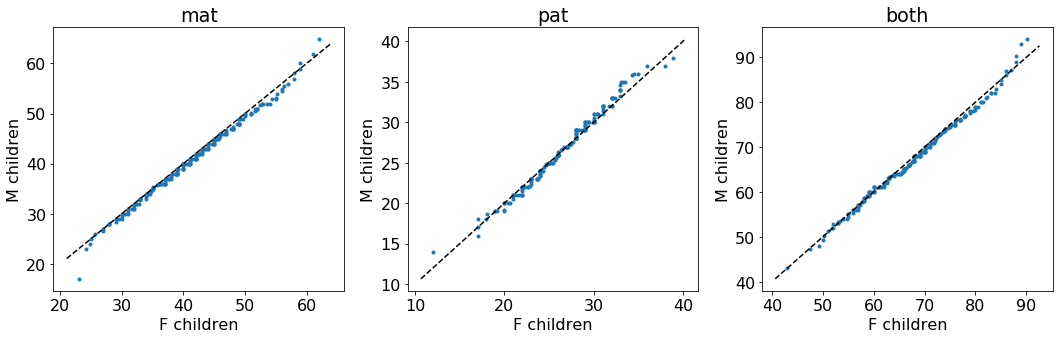

In [106]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 5))

f_children = [x for x in child_to_num_crossovers_mat.keys() if sample_to_sex[x]=='2']
m_children = [x for x in child_to_num_crossovers_mat.keys() if sample_to_sex[x]=='1']

bins = np.arange(0, 1, 0.005)

plt.subplot(1, 3, 1)
plt.scatter(np.quantile([child_to_num_crossovers_mat[x] for x in f_children], bins), 
            np.quantile([child_to_num_crossovers_mat[x] for x in m_children], bins),
            label='mat', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('mat')
plt.xlabel('F children')
plt.ylabel('M children')

plt.subplot(1, 3, 2)
plt.scatter(np.quantile([child_to_num_crossovers_pat[x] for x in f_children], bins), 
            np.quantile([child_to_num_crossovers_pat[x] for x in m_children], bins),
            label='pat', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('pat')
plt.xlabel('F children')
plt.ylabel('M children')

plt.subplot(1, 3, 3)
plt.scatter(np.quantile([child_to_num_crossovers_mat[x]+child_to_num_crossovers_pat[x] for x in f_children], bins), 
            np.quantile([child_to_num_crossovers_mat[x]+child_to_num_crossovers_pat[x] for x in m_children], bins),
            label='both', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('both')
plt.xlabel('F children')
plt.ylabel('M children')

plt.tight_layout()
plt.show()

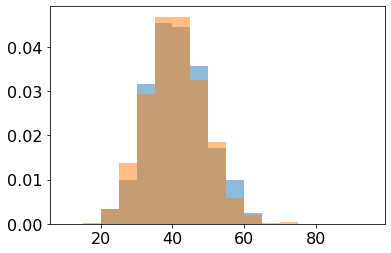

In [111]:
plt.hist([child_to_num_crossovers_mat[x] for x in f_children], alpha=0.5, bins=np.arange(10, 100, 5), density=True)
plt.hist([child_to_num_crossovers_mat[x] for x in m_children], alpha=0.5, bins=np.arange(10, 100, 5), density=True)
plt.show()

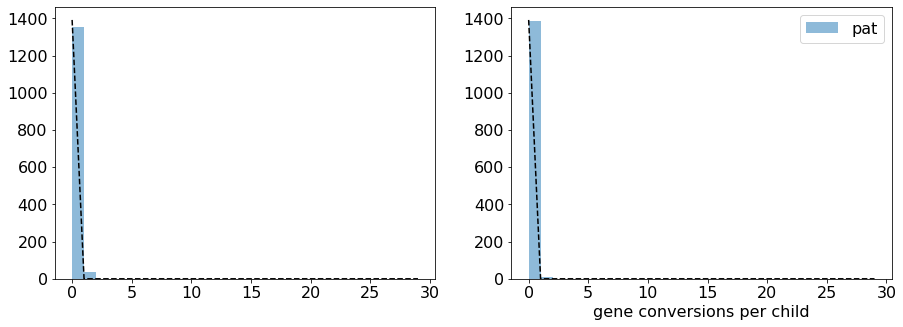

In [43]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(child_to_num_gcs_mat.values(), bins=np.arange(0, 30), alpha=0.5, label='mat')
plt.plot(np.arange(30), len(child_to_num_gcs_mat)*stats.poisson.pmf(np.arange(30), 
                                                                 np.median(list(child_to_num_gcs_mat.values()))), color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(child_to_num_gcs_pat.values(), bins=np.arange(0, 30), alpha=0.5, label='pat')
plt.plot(np.arange(30), len(child_to_num_gcs_mat)*stats.poisson.pmf(np.arange(30), 
                                                                 np.median(list(child_to_num_gcs_pat.values()))), color='black', linestyle='--')
plt.legend()
plt.xlabel('gene conversions per child')

plt.show()

# Check maternal/paternal age at birth

In [44]:
# pull parental ages
#child_to_mom_age_at_birth = dict()
#child_to_dad_age_at_birth = dict()
#with open('../phenotypes/mssng/agre_affchild1.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    mat_age_index = header.index('MATERNAL_AGE_AT_PARTURITION')
#    pat_age_index = header.index('PATERNAL_AGE_AT_PARTURITION')
#    for pieces in reader:
#        if float(pieces[mat_age_index]) > 10:
#            child_to_mom_age_at_birth[pieces[0]] = float(pieces[mat_age_index])
#        if float(pieces[pat_age_index]) > 10:
#            child_to_dad_age_at_birth[pieces[0]] = float(pieces[pat_age_index])
#print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))


In [45]:
person_to_age = dict()
with open('../phenotypes/spark/individuals.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    age_index = header.index('age_at_registration_months')
    for pieces in reader:
        person_to_age[pieces[0]] = int(pieces[age_index])/12

In [46]:
#with open('../phenotypes/mssng/rmq.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    mat_age_index = header.index('MOMAGE')
#    pat_age_index = header.index('DADAGE')
#    for pieces in reader:
#        try:
#            child_to_mom_age_at_birth[pieces[0]] = float(pieces[mat_age_index])
#        except ValueError:
#            pass
#        try:
#            child_to_dad_age_at_birth[pieces[0]] = float(pieces[pat_age_index])
#        except ValueError:
#            pass
#print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))


In [47]:
#person_to_birthyear = dict()
#filenames = ['../phenotypes/ihart/Medical History Mother/MotherH1.csv',
#             '../phenotypes/ihart/Medical History Father/FatherH1.csv',
#             '../phenotypes/ihart/Medical History Affected Child/AffChild1.csv',
#             '../phenotypes/ihart/Medical History Unaffected Child/Unaffec1.csv',
#             '../phenotypes/ihart/Language Questionnaire/Language_Questionnaire1.csv',
#             '../phenotypes/ihart/Handedness/Hands1.csv',
#             '../phenotypes/ihart/AGRE_PhysMeas1.csv',
#             '../phenotypes/ihart/AGRE Physical Measurements/AGRE_PhysMeas1.csv',
#            ]
#
#for filename in filenames:
#    print(filename)
#    with open(filename, 'r') as f:
#        reader = csv.reader(f)
#        header = next(reader)
#        age_index = header.index('age')
#        sample_id_index = header.index('Individual ID')
#        date_index = header.index('data_entry_date')
#        for pieces in reader:
#            try:
#                birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
#                person_to_birthyear[pieces[sample_id_index]] = birth_year
#            except ValueError:
#                pass
#            
#with open('../phenotypes/mssng/bodymeas.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    age_index = header.index('AgeN')
#    sample_id_index = header.index('Id')
#    date_index = header.index('testdate')
#    for pieces in reader:
#        try:
#            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
#            person_to_birthyear[pieces[sample_id_index]] = birth_year
#        except ValueError:
#            pass
#        
#with open('../phenotypes/mssng/srsadultresearchform.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    age_index = header.index('SRSAAGE')
#    sample_id_index = header.index('Id')
#    date_index = header.index('testdate')
#    for pieces in reader:
#        try:
#            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
#            person_to_birthyear[pieces[sample_id_index]] = birth_year
#        except ValueError:
#            pass
#        
#with open('../phenotypes/mssng/srsparentreportforchild.csv', 'r') as f:
#    reader = csv.reader(f)
#    header = next(reader)
#    age_index = header.index('SRSAGE')
#    sample_id_index = header.index('Id')
#    date_index = header.index('testdate')
#    for pieces in reader:
#        try:
#            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
#            person_to_birthyear[pieces[sample_id_index]] = birth_year
#        except ValueError:
#            pass
#
#filenames = ['../phenotypes/mssng/agre_srs2srs20021.csv',
#             '../phenotypes/mssng/agre_srs2006preschool1.csv',
#             '../phenotypes/mssng/agre_srs20061.csv',
#            ]
#for filename in filenames:
#    with open(filename, 'r') as f:
#        reader = csv.reader(f)
#        header = next(reader)
#        age_index = header.index('AGE')
#        sample_id_index = header.index('Id')
#        date_index = header.index('testdate')
#        for pieces in reader:
#            try:
#                birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
#                person_to_birthyear[pieces[sample_id_index]] = birth_year
#            except ValueError:
#                pass#
#
#        
#filenames = ['../phenotypes/ihart/SRS/SRS_2006_Preschool1.csv',
#            '../phenotypes/ihart/SRS/SRS_20061_Adult.csv',
#            '../phenotypes/ihart/SRS/SRS_20061_Child.csv',
#            '../phenotypes/ihart/SRS/SRS_20061.csv',
#            '../phenotypes/ihart/SRS/SRS2_SRS20021_Child.csv',
#            '../phenotypes/ihart/SRS/SRS2_SRS20021_Preschool.csv',
#            '../phenotypes/ihart/SRS/SRS2_SRS20021.csv'
#            ]
#for filename in filenames:
#    with open(filename, 'r') as f:
#        reader = csv.reader(f)
#        header = next(reader)
#        age_index = header.index('age')
#        sample_id_index = header.index('Individual ID')
#        year_index = header.index('InterviewYear')
#        month_index = header.index('InterviewMonth')
#        day_index = header.index('InterviewDay')
#        for pieces in reader:
#            try:
#                birth_year = (datetime.date(int(pieces[year_index]), int(pieces[month_index]), int(pieces[day_index])) - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
#                person_to_birthyear[pieces[sample_id_index]] = birth_year
#            except ValueError:
#                pass
#print(len(person_to_birthyear))


In [48]:
#plt.hist(person_to_birthyear.values(), bins=np.arange(1930, 2020, 5))
#plt.show()

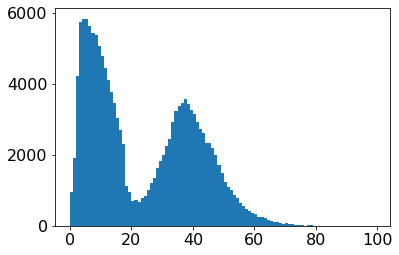

In [49]:
plt.hist(person_to_age.values(), bins=np.arange(0, 100))
plt.show()

In [50]:
#
#child_to_mom_age_at_birth, child_to_dad_age_at_birth = dict(), dict()
#missing_mom, missing_child = 0, 0
#for mom, child in mom_child_pairs:
#    if mom in person_to_birthyear and child in person_to_birthyear:
#        age_at_birth = person_to_birthyear[child] - person_to_birthyear[mom]
#        if age_at_birth > 10 and age_at_birth < 50:
#            child_to_mom_age_at_birth[child] = age_at_birth
#    elif mom in person_to_birthyear:
#        missing_child += 1
#    elif child in person_to_birthyear:
#        missing_mom += 1
#for dad, child in dad_child_pairs:
#    if dad in person_to_birthyear and child in person_to_birthyear:
#        age_at_birth = person_to_birthyear[child] - person_to_birthyear[dad]
#        if age_at_birth > 10 and age_at_birth < 50:
#            child_to_dad_age_at_birth[child] = age_at_birth
#print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))
#print(missing_child, missing_mom)
              

In [151]:
child_to_mom = dict([(child, mom) for mom, child in mom_child_pairs])
child_to_dad = dict([(child, dad) for dad, child in dad_child_pairs])

In [153]:
sibpairs = [x for x in (sibpair_to_num_crossovers_mat.keys() & sibpair_to_num_crossovers_pat.keys()) if x[0] in person_to_age and x[1] in person_to_age and \
           child_to_mom[x[0]] in person_to_age and child_to_dad[x[0]] in person_to_age and \
            child_to_mom[x[1]] in person_to_age and child_to_dad[x[1]] in person_to_age]
sibpair_age_mom = []
sibpair_age_dad = []
sibpair_recomb_mat = []
sibpair_recomb_pat = []
for sib1, sib2 in sibpairs:
    sibpair_age_mom.append((person_to_age[child_to_mom[sib1]]-person_to_age[sib1])+(person_to_age[child_to_mom[sib2]]-person_to_age[sib2]))
    sibpair_age_dad.append((person_to_age[child_to_dad[sib1]]-person_to_age[sib1])+(person_to_age[child_to_dad[sib2]]-person_to_age[sib2]))
    sibpair_recomb_mat.append(sibpair_to_num_crossovers_mat[(sib1, sib2)])
    sibpair_recomb_pat.append(sibpair_to_num_crossovers_pat[(sib1, sib2)])
    
print(len(sibpairs))

5551


In [143]:
child_to_mom_age_at_birth, child_to_dad_age_at_birth = dict(), dict()
missing_mom, missing_dad, missing_child = 0, 0, 0
for mom, child in mom_child_pairs:
    if mom in person_to_age and child in person_to_age:
        age_at_birth = person_to_age[mom] - person_to_age[child]
        if age_at_birth > 10 and age_at_birth < 50:
            child_to_mom_age_at_birth[child] = age_at_birth
    elif mom in person_to_age:
        missing_child += 1
    elif child in person_to_age:
        missing_mom += 1
for dad, child in dad_child_pairs:
    if dad in person_to_age and child in person_to_age:
        age_at_birth = person_to_age[dad] - person_to_age[child]
        if age_at_birth > 10 and age_at_birth < 50:
            child_to_dad_age_at_birth[child] = age_at_birth
    elif dad in person_to_age:
        missing_child += 1
    elif child in person_to_age:
        missing_dad += 1  
print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))
print(missing_child, missing_mom, missing_dad)  

9568 9442
13 2 66


In [71]:
print(len(child_to_mom_age_at_birth))
children_to_include = set(child_to_num_crossovers_mat.keys()) & set(child_to_mom_age_at_birth.keys()) & set(child_to_dad_age_at_birth.keys())
print('have ages for ', len(children_to_include))
print('missing ages for ', len(set(child_to_num_crossovers_mat.keys()) & set(child_to_num_crossovers_pat.keys()) - children_to_include))
      
children_to_include = sorted(children_to_include)
      

9568
have ages for  1099
missing ages for  293


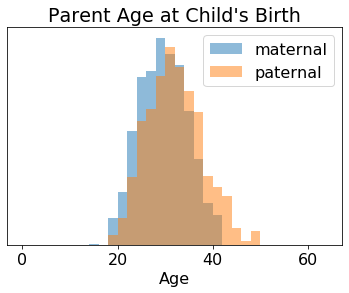

In [72]:
plt.hist(np.clip([child_to_mom_age_at_birth[x] for x in children_to_include], 0, 64),
        alpha=0.5, bins=np.arange(0, 65, 2), label='maternal')
plt.hist(np.clip([child_to_dad_age_at_birth[x] for x in children_to_include], 0, 64),
        alpha=0.5, bins=np.arange(0, 65, 2), label='paternal')
plt.title("Parent Age at Child's Birth")
plt.legend()
plt.xlabel('Age')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()


In [102]:
mom_age, mom_recomb, mom_gc = np.zeros((len(children_to_include),), dtype=int), np.zeros((len(children_to_include),), dtype=int), np.zeros((len(children_to_include),), dtype=int)
dad_age, dad_recomb, dad_gc = np.zeros((len(children_to_include),), dtype=int), np.zeros((len(children_to_include),), dtype=int), np.zeros((len(children_to_include),), dtype=int)
mom_phenotype, dad_phenotype = np.zeros((len(children_to_include),), dtype=bool), np.zeros((len(children_to_include),), dtype=bool)
mom_family, dad_family = np.zeros((len(children_to_include),), dtype=bool), np.zeros((len(children_to_include),), dtype=bool)

for i, child in enumerate(children_to_include):
    mom_age[i] = child_to_mom_age_at_birth[child]
    mom_recomb[i] = child_to_num_crossovers_mat[child]
    mom_gc[i] = child_to_num_gcs_mat[child]
    mom_phenotype[i] = sample_to_affected[child]=='2'
    
    dad_age[i] = child_to_dad_age_at_birth[child]
    dad_recomb[i] = child_to_num_crossovers_pat[child]
    dad_gc[i] = child_to_num_gcs_pat[child]
    dad_phenotype[i] = sample_to_affected[child]=='2'

In [170]:

mat_model = sm.GLM(sibpair_recomb_mat, np.hstack((#mom_age[:, np.newaxis]**2, 
                                          np.array(sibpair_age_mom)[:, np.newaxis], 
                                          np.array(sibpair_age_dad)[:, np.newaxis], 
                                          #dad_age[:, np.newaxis]**2, 
                                          #dad_age[:, np.newaxis], 
                                          #mom_age[:, np.newaxis]*dad_age[:, np.newaxis],
                                          np.ones((len(sibpair_recomb_mat), 1))
                )), family=Poisson())
mat_results = mat_model.fit()
print(mat_results.summary())

print(np.exp(mat_results.params))


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5551
Model:                            GLM   Df Residuals:                     5548
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22405.
Date:                Tue, 20 Jul 2021   Deviance:                       10172.
Time:                        10:48:23   Pearson chi2:                 1.02e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.000      2.458      0.0

In [164]:

mat_model = sm.GLM(sibpair_recomb_pat, np.hstack((#mom_age[:, np.newaxis]**2, 
                                          np.array(sibpair_age_mom)[:, np.newaxis], 
                                          np.array(sibpair_age_dad)[:, np.newaxis], 
                                          #dad_age[:, np.newaxis]**2, 
                                          #dad_age[:, np.newaxis], 
                                          #mom_age[:, np.newaxis]*dad_age[:, np.newaxis],
                                          np.ones((len(sibpair_recomb_mat), 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 5551
Model:                            GLM   Df Residuals:                     5548
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18329.
Date:                Tue, 20 Jul 2021   Deviance:                       4402.0
Time:                        10:44:33   Pearson chi2:                 4.40e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0004      0.000      1.486      0.137      -0.000       0.001
x2            -0.0006      0.000     -3.041      0.002      -0.001      -0.000
const          3.9957      0.012    321.463      0.000       3.971       4.020
==============================================================================
"""

In [84]:

mat_model = sm.GLM(mom_recomb, np.hstack((#mom_age[:, np.newaxis]**2, 
                                          mom_age[:, np.newaxis], 
                                          #dad_age[:, np.newaxis]**2, 
                                          #dad_age[:, np.newaxis], 
                                          #mom_age[:, np.newaxis]*dad_age[:, np.newaxis],
                                          np.ones((mom_age.shape[0], 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                            GLM   Df Residuals:                     1097
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3938.5
Date:                Tue, 20 Jul 2021   Deviance:                       1807.2
Time:                        10:04:15   Pearson chi2:                 1.80e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0006      0.001     -0.620      0.535      -0.002       0.001
const          3.7187      0.028    132.886      0.000       3.664       3.774
==============================================================================
"""

array([ 3.90018727e-04, -6.47600710e-04,  3.99568519e+00])

In [85]:

dad_model = sm.GLM(dad_recomb, np.hstack((#mom_age[:, np.newaxis],
                                          dad_age[:, np.newaxis], 
                                                    #dad_phenotype[:, np.newaxis],
                                                    np.ones((dad_age.shape[0], 1)))), family=Poisson())
dad_results = dad_model.fit()
dad_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                            GLM   Df Residuals:                     1097
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3193.2
Date:                Tue, 20 Jul 2021   Deviance:                       795.10
Time:                        10:04:19   Pearson chi2:                     796.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0033      0.001     -3.193      0.001      -0.005      -0.001
const          3.3597      0.033    103.255      0.000       3.296       3.423
==============================================================================
"""

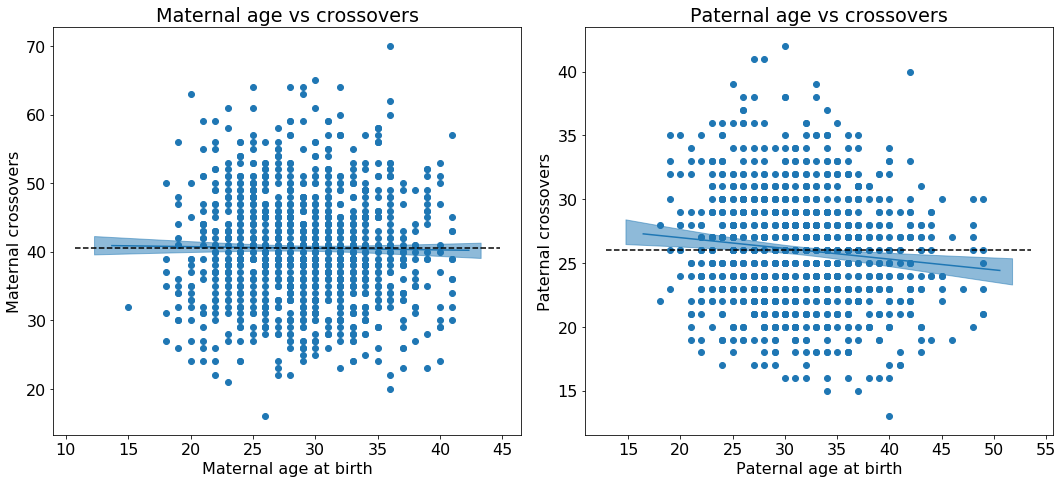

In [86]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(np.array(mom_age), np.array(mom_recomb))
plt.plot(plt.xlim(), np.exp(mat_results.params[1] + mat_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(mom_recomb)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Maternal age at birth')
plt.ylabel('Maternal crossovers')
plt.title('Maternal age vs crossovers')

plt.subplot(1, 2, 2)
plt.scatter(np.array(dad_age), np.array(dad_recomb))
plt.plot(plt.xlim(), np.exp(dad_results.params[1] + dad_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(dad_recomb)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Paternal age at birth')
plt.ylabel('Paternal crossovers')
plt.title('Paternal age vs crossovers')

plt.tight_layout()
plt.show()

In [88]:

mat_model = sm.GLM(np.array(mom_gc), np.hstack((np.array(mom_age)[:, np.newaxis], 
                                                #mom_phenotype[:, np.newaxis],
                                                np.ones((mom_age.shape[0], 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                            GLM   Df Residuals:                     1097
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -136.61
Date:                Tue, 20 Jul 2021   Deviance:                       214.60
Time:                        10:04:56   Pearson chi2:                 1.09e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0749      0.037      2.047      0.041       0.003       0.147
const         -5.8571      1.151     -5.087      0.000      -8.114      -3.601
==============================================================================
"""

In [89]:

dad_model = sm.GLM(np.array(dad_gc), np.hstack((np.array(dad_age)[:, np.newaxis], 
                                                #dad_phenotype[:, np.newaxis],
                                                np.ones((dad_age.shape[0], 1)))), family=Poisson())
dad_results = dad_model.fit()
dad_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                            GLM   Df Residuals:                     1097
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.870
Date:                Tue, 20 Jul 2021   Deviance:                       61.739
Time:                        10:04:56   Pearson chi2:                 1.09e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0599      0.067      0.900      0.368      -0.071       0.191
const         -7.1629      2.280     -3.141      0.002     -11.632      -2.694
==============================================================================
"""

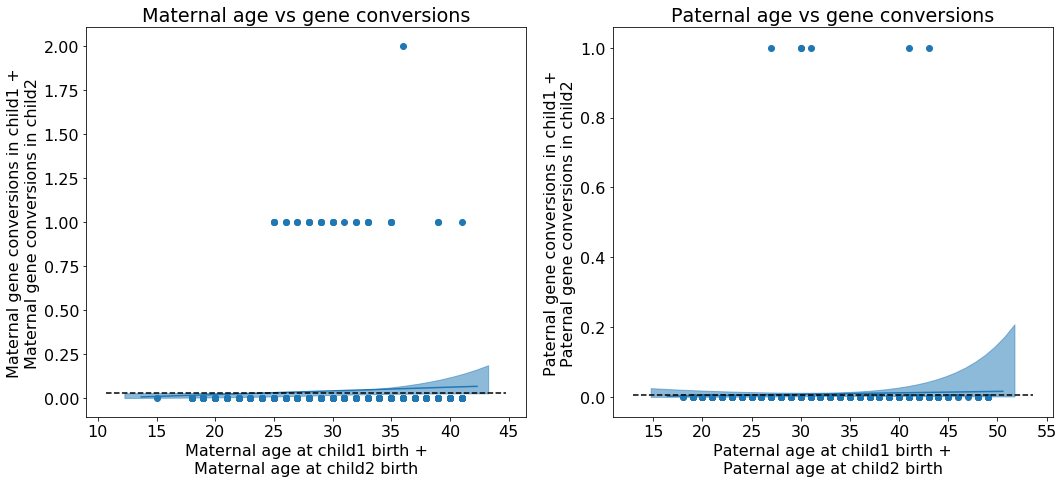

In [90]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(np.array(mom_age), np.array(mom_gc))
plt.plot(plt.xlim(), np.exp(mat_results.params[1] + mat_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(mom_gc)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Maternal age at child1 birth +\nMaternal age at child2 birth')
plt.ylabel('Maternal gene conversions in child1 +\nMaternal gene conversions in child2')
plt.title('Maternal age vs gene conversions')

plt.subplot(1, 2, 2)
plt.scatter(np.array(dad_age), np.array(dad_gc))
plt.plot(plt.xlim(), np.exp(dad_results.params[1] + dad_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(dad_gc)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Paternal age at child1 birth +\nPaternal age at child2 birth')
plt.ylabel('Paternal gene conversions in child1 +\nPaternal gene conversions in child2')
plt.title('Paternal age vs gene conversions')

plt.tight_layout()
plt.show()

In [91]:

mat_model = sm.GLM(np.array(dad_recomb), np.hstack((np.array(mom_recomb)[:, np.newaxis], 
                                                np.ones((mom_gc.shape[0], 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                            GLM   Df Residuals:                     1097
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3198.3
Date:                Tue, 20 Jul 2021   Deviance:                       805.28
Time:                        10:05:30   Pearson chi2:                     807.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001      0.001      0.179      0.858      -0.001       0.002
const          3.2521      0.030    108.328      0.000       3.193       3.311
==============================================================================
"""

In [92]:

pat_model = sm.GLM(np.array(dad_gc), np.hstack((np.array(dad_recomb)[:, np.newaxis], 
                                                np.ones((dad_gc.shape[0], 1)))), family=Poisson())
pat_results = pat_model.fit()
pat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                            GLM   Df Residuals:                     1097
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.723
Date:                Tue, 20 Jul 2021   Deviance:                       61.446
Time:                        10:05:40   Pearson chi2:                 1.07e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1011      0.099     -1.018      0.309      -0.296       0.094
const         -2.6770      2.434     -1.100      0.271      -7.448       2.094
==============================================================================
"""

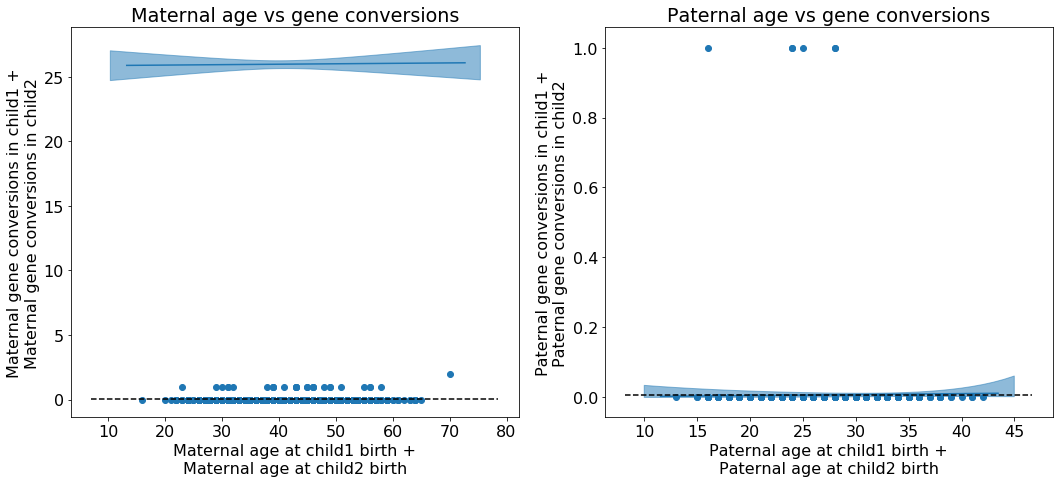

In [93]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(np.array(mom_recomb), np.array(mom_gc))
plt.plot(plt.xlim(), np.exp(mat_results.params[1] + mat_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(mom_gc)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Maternal age at child1 birth +\nMaternal age at child2 birth')
plt.ylabel('Maternal gene conversions in child1 +\nMaternal gene conversions in child2')
plt.title('Maternal age vs gene conversions')

plt.subplot(1, 2, 2)
plt.scatter(np.array(dad_recomb), np.array(dad_gc))
plt.plot(plt.xlim(), np.exp(dad_results.params[1] + dad_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(dad_gc)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Paternal age at child1 birth +\nPaternal age at child2 birth')
plt.ylabel('Paternal gene conversions in child1 +\nPaternal gene conversions in child2')
plt.title('Paternal age vs gene conversions')

plt.tight_layout()
plt.show()

# Any phenotype association?

In [115]:
phenotype = []
sex = []

for child in children_to_include:
    phenotype.append(sample_to_affected[child]=='2')
    sex.append(sample_to_sex[child]=='1')

phenotype = np.array(phenotype)
sex = np.array(sex)

In [116]:
print(np.sum(phenotype), np.sum(~phenotype))
print(np.sum(sex), np.sum(~sex))

753 346
713 386


In [118]:
print((sex & phenotype)[:, np.newaxis])

[[ True]
 [ True]
 [False]
 ...
 [ True]
 [ True]
 [ True]]


In [128]:

mat_model = sm.Logit(phenotype, np.hstack((sex[:, np.newaxis].astype(int),
                                           (~sex[:, np.newaxis]).astype(int),
                                          mom_recomb[:, np.newaxis] * sex[:, np.newaxis].astype(int),
                                           mom_recomb[:, np.newaxis] * (~sex[:, np.newaxis]).astype(int),
                                         #mom_recomb[:, np.newaxis]**2,
                                          dad_recomb[:, np.newaxis] * sex[:, np.newaxis].astype(int),
                                          dad_recomb[:, np.newaxis] * (~sex[:, np.newaxis]).astype(int),
                                           #dad_recomb[:, np.newaxis]**2,
                                           #mom_recomb[:, np.newaxis]*dad_recomb[:, np.newaxis],
                                          #np.ones((mom_recomb.shape[0], 1))
                                         )), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()



Optimization terminated successfully.
         Current function value: 0.585634
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                          Logit   Df Residuals:                     1093
Method:                           MLE   Df Model:                            5
Date:                Tue, 20 Jul 2021   Pseudo R-squ.:                 0.05984
Time:                        10:20:51   Log-Likelihood:                -643.61
converged:                       True   LL-Null:                       -684.58
Covariance Type:            nonrobust   LLR p-value:                 3.300e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3613      0.701      1.941      0.052      -0.013       2.736
x2             1.1391      0.804      1.416      0.157      -0.437       2.716
x3            -0.0114      0.011     -1.031      0.303      -0.033       0.010
x4            -0.0008      0.013     -0.064      0.949      -0.026       0.024
x5             0.0133      0.020      0.654      0.513      -0.027       0.053
x6            -0.0402      0.024     -1.640      0.101      -0.088       0.008
==============================================================================
"""

In [120]:

mat_model = sm.GLM(mom_recomb, np.hstack((sex[:, np.newaxis].astype(int),
                                          phenotype[:, np.newaxis].astype(int),
                                          (sex & phenotype)[:, np.newaxis].astype(int),
                                          np.ones((mom_recomb.shape[0], 1))
                                         )), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                            GLM   Df Residuals:                     1095
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3933.3
Date:                Tue, 20 Jul 2021   Deviance:                       1796.9
Time:                        10:16:12   Pearson chi2:                 1.79e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0164      0.017     -0.973      0.330      -0.049       0.017
x2            -0.0033      0.016     -0.210      0.834      -0.034       0.028
x3            -0.0157      0.021     -0.737      0.461      -0.057       0.026
const          3.7223      0.011    327.348      0.000       3.700       3.745
==============================================================================
"""

In [121]:

pat_model = sm.GLM(dad_recomb, np.hstack((sex[:, np.newaxis].astype(int),
                                          phenotype[:, np.newaxis].astype(int),
                                          (sex & phenotype)[:, np.newaxis].astype(int),
                                          np.ones((mom_recomb.shape[0], 1))
                                         )), family=Poisson())
pat_results = pat_model.fit()
pat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1099
Model:                            GLM   Df Residuals:                     1095
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3197.2
Date:                Tue, 20 Jul 2021   Deviance:                       803.10
Time:                        10:16:48   Pearson chi2:                     805.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0218      0.021     -1.032      0.302      -0.063       0.020
x2            -0.0273      0.020     -1.366      0.172      -0.066       0.012
x3             0.0377      0.027      1.412      0.158      -0.015       0.090
const          3.2712      0.014    229.589      0.000       3.243       3.299
==============================================================================
"""

In [795]:

print(np.sum(phenotype==0), np.sum(phenotype==1))
model = sm.Logit(phenotype, np.hstack((mat_cross[:, np.newaxis],
                                         mat_gc[:, np.newaxis], 
                                         pat_cross[:, np.newaxis], 
                                         pat_gc[:, np.newaxis], 
                                         (sex==1)[:, np.newaxis],
                                         np.ones((phenotype.shape[0], 1)))))
results = model.fit(disp=False)
results.summary()


352 890


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1242
Model:                          Logit   Df Residuals:                     1236
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Jan 2021   Pseudo R-squ.:                 0.06493
Time:                        13:48:19   Log-Likelihood:                -692.34
converged:                       True   LL-Null:                       -740.42
Covariance Type:            nonrobust   LLR p-value:                 3.410e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0034      0.008      0.437      0.662      -0.012       0.018
x2            -0.0536      0.022     -2.412      0.016      -0.097      -0.010
x3            -0.0030      0.015     -0.203      0.839      -0.032       0.026
x4            -0.0610      0.025     -2.408      0.016      -0.111      -0.011
x5             1.2260      0.134      9.134      0.000       0.963       1.489
const          0.7504      0.548      1.369      0.171      -0.324       1.825
==============================================================================
"""

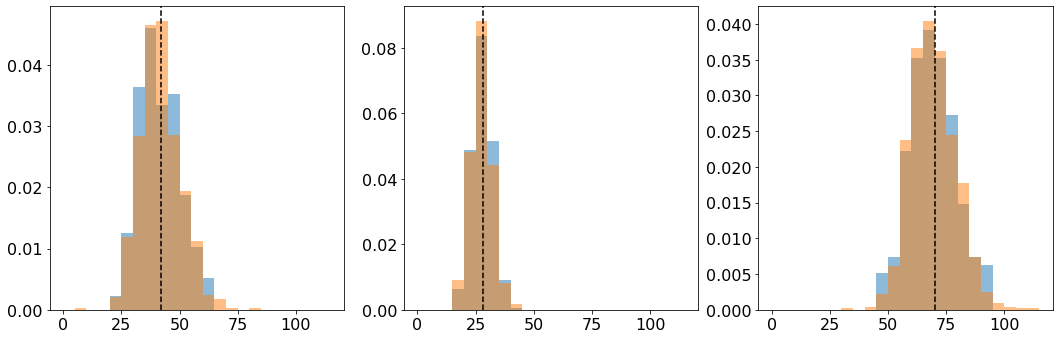

In [796]:
plt.figure(figsize=(15, 5))

bins = np.arange(0, 120, 5)

plt.subplot(1, 3, 1)
#plt.violinplot([mat_gc[phenotype==0],
#                mat_gc[phenotype==1],], showmedians=True, showextrema=True)
plt.hist(mat_cross[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_cross[phenotype==1], bins=bins, alpha=0.5, density=True)
plt.axvline(42, color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.hist(pat_cross[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(pat_cross[phenotype==1], bins=bins, alpha=0.5, density=True)
plt.axvline(28, color='black', linestyle='--')

plt.subplot(1, 3, 3)
plt.hist(mat_cross[phenotype==0]+pat_cross[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_cross[phenotype==1]+pat_cross[phenotype==1], bins=bins, alpha=0.5, density=True)
plt.axvline(42+28, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [797]:

print(np.sum(phenotype==0), np.sum(phenotype==1))
model = sm.Logit(phenotype, np.hstack((mat_cross[:, np.newaxis]+mat_gc[:, np.newaxis], 
                                       pat_cross[:, np.newaxis]+pat_gc[:, np.newaxis], 
                                         (sex==1)[:, np.newaxis],
                                         np.ones((phenotype.shape[0], 1)))))
results = model.fit(disp=False)
results.summary()


352 890


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1242
Model:                          Logit   Df Residuals:                     1238
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Jan 2021   Pseudo R-squ.:                 0.05667
Time:                        13:48:20   Log-Likelihood:                -698.45
converged:                       True   LL-Null:                       -740.42
Covariance Type:            nonrobust   LLR p-value:                 4.413e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0042      0.007     -0.590      0.555      -0.018       0.010
x2            -0.0224      0.013     -1.781      0.075      -0.047       0.002
x3             1.1784      0.132      8.907      0.000       0.919       1.438
const          1.1285      0.529      2.133      0.033       0.092       2.165
==============================================================================
"""

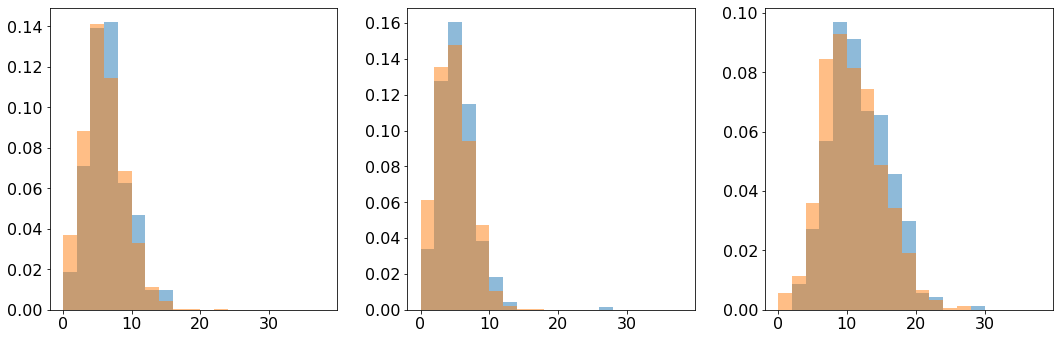

In [798]:
plt.figure(figsize=(15, 5))

bins = np.arange(0, 40, 2)

plt.subplot(1, 3, 1)
#plt.violinplot([mat_gc[phenotype==0],
#                mat_gc[phenotype==1],], showmedians=True, showextrema=True)
plt.hist(mat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.subplot(1, 3, 2)
plt.hist(pat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(pat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.subplot(1, 3, 3)
plt.hist(mat_gc[phenotype==0]+pat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_gc[phenotype==1]+pat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.tight_layout()
plt.show()

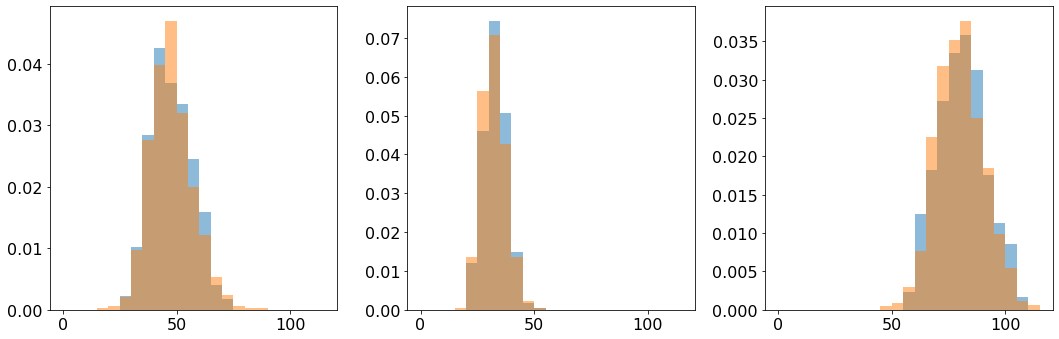

In [800]:
plt.figure(figsize=(15, 5))

bins = np.arange(0, 120, 5)

plt.subplot(1, 3, 1)
#plt.violinplot([mat_gc[phenotype==0],
#                mat_gc[phenotype==1],], showmedians=True, showextrema=True)
plt.hist(mat_cross[phenotype==0]+mat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_cross[phenotype==1]+mat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.subplot(1, 3, 2)
plt.hist(pat_cross[phenotype==0]+pat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(pat_cross[phenotype==1]+pat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.subplot(1, 3, 3)
plt.hist(mat_cross[phenotype==0]+pat_cross[phenotype==0]+mat_gc[phenotype==0]+pat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_cross[phenotype==1]+pat_cross[phenotype==1]+mat_gc[phenotype==1]+pat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.tight_layout()
plt.show()